In [248]:
import numpy as np
import pandas as pd
# import matplotlib
# matplotlib.usee('TKAgg')
from matplotlib import pyplot as plt
import csv
import requests

import datetime
import time
from chinese_calendar import is_holiday

from pandas.api.types import CategoricalDtype

In [139]:
%matplotlib inline

In [5]:
df_user_order_detail = pd.read_csv(r'../input/car8865/用户基础数据.csv',
                              dtype={'trade_order_id':object,'uid':object,'gid':object,'passenger_phone':object,'platform':object,
                                    'service_type':int,'service_type_name':object,'order_status':int,'order_status_name':object,
                                    'order_day':object,'book_day':object,'order_car_type_id':int,'order_car_type_name':object,
                                    'city_code':object,'city_name':object,'channel_id':int,'channel_name':object,
                                    'first_token_driver_taken_type':object,'first_token_driver_taken_type':object,'order_car_type_id':int,
                                     'order_car_type_name':object,'source_type':int,'source_type_name':object},encoding='utf-8')

In [10]:
df_user_order_detail.head()

,trade_order_id,uid,gid,passenger_phone,platform,service_type,service_type_name,order_status,order_status_name,order_day,...,city_code,city_name,channel_id,channel_name,first_taken_driver_taken_type,first_taken_driver_taken_type_name,order_car_type_id.1,order_car_type_name.1,source_type,source_type_name
0,E181619485232,868385039047457,BB7C5279-95E1-DA88-EC0D-9A358E56AB73,186VU265589,Q,3,城市交通（时租）,7,已确认款项,2018-08-11,...,sanya,三亚,60,Android,100,OTA司机接单,99,出租车,12,OTA
1,E181645360215,E7663F36-6C35-4DDA-BEB3-2897F4ED35BC,69093625-85FA-A7B7-F485-0C8AB5404A88,139svlo3695,Q,3,城市交通（时租）,7,已确认款项,2018-09-06,...,shanghai_city,上海,80,iPhone,100,OTA司机接单,5,商务型,12,OTA
2,E181680198260,866229036251187,9AA77171-6B71-0946-0D7A-A21D4DCE2873,186r8ar1007,Q,3,城市交通（时租）,7,已确认款项,2018-10-11,...,wuhan,武汉,60,Android,100,OTA司机接单,99,出租车,12,OTA
3,E181781813380,866693026884317,0EC31567-3910-FA5F-4B13-B1C8FB262628,138gNTQ9157,Q,3,城市交通（时租）,8,取消,2019-01-20,...,nanjing,南京,60,Android,100,OTA司机接单,99,出租车,12,OTA
4,E181787631459,273ECCB0-AA83-4766-8013-C2D22DF0D6A0,97FE372C-B013-A68E-7A17-A44FEAF7E46A,182tpRS3656,Q,2,接机,8,取消,2019-01-26,...,shenyang,沈阳,80,iPhone,100,OTA司机接单,2,舒适型,12,OTA


In [11]:
df_user_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
trade_order_id                        10000 non-null object
uid                                   10000 non-null object
gid                                   10000 non-null object
passenger_phone                       10000 non-null object
platform                              10000 non-null object
service_type                          10000 non-null int32
service_type_name                     10000 non-null object
order_status                          10000 non-null int32
order_status_name                     10000 non-null object
order_day                             10000 non-null object
book_day                              10000 non-null object
order_car_type_id                     10000 non-null int32
order_car_type_name                   10000 non-null object
order_order_class_id                  10000 non-null int64
order_order_class_name                10000 non-null obj

In [15]:
df_user_order_detail.duplicated().value_counts()

False    10000
dtype: int64

In [25]:
df_na = df_user_order_detail[df_user_order_detail.apply(lambda x:x==0) | (df_user_order_detail.apply(lambda x:x==0))].dropna(axis=0,how='all')
df_na.shape

(0, 25)

In [189]:
def date_extension(row):
    use_immediate = 1 if row['order_day'] == row['book_day'] else 0
    # 待补充：计算预定和提车日期差
    order_date_tuple = time.strptime(row['order_day'],'%Y-%m-%d')[:3]
    book_date_tuple = time.strptime(row['book_day'],'%Y-%m-%d')[:3]
    order_month = order_date_tuple[1]
    book_month = book_date_tuple[1]
    r_order_date = 1 if is_holiday(datetime.date(order_date_tuple[0],order_date_tuple[1],order_date_tuple[2])) else 0
    r_book_date = 1 if is_holiday(datetime.date(book_date_tuple[0],book_date_tuple[1],book_date_tuple[2])) else 0
    return r_order_date,r_book_date,use_immediate,order_month,book_month

In [190]:
df_user_order_detail[['is_bookdate_holiday','is_orderdate_holiday','use_immediate','order_month','book_month']] = df_user_order_detail.apply(date_extension,axis=1,result_type='expand')

In [191]:
df_user_order_detail.columns

Index(['trade_order_id', 'uid', 'gid', 'passenger_phone', 'platform',
       'service_type', 'service_type_name', 'order_status',
       'order_status_name', 'order_day', 'book_day', 'order_car_type_id',
       'order_car_type_name', 'order_order_class_id', 'order_order_class_name',
       'city_code', 'city_name', 'channel_id', 'channel_name',
       'first_taken_driver_taken_type', 'first_taken_driver_taken_type_name',
       'order_car_type_id.1', 'order_car_type_name.1', 'source_type',
       'source_type_name', 'is_bookdate_holiday', 'is_orderdate_holiday',
       'use_immediate', 'order_month', 'book_month'],
      dtype='object')

In [192]:
df_user_order_detail[['is_bookdate_holiday','is_orderdate_holiday','use_immediate','order_month','book_month']]

,is_bookdate_holiday,is_orderdate_holiday,use_immediate,order_month,book_month
0,1,1,1,8,8
1,0,0,1,9,9
2,0,0,1,10,10
3,1,1,1,1,1
4,1,0,0,1,2
...,...,...,...,...,...
9995,0,0,0,8,8
9996,1,1,0,10,10
9997,0,0,0,1,1
9998,0,0,1,5,5


In [119]:
plt.rcParams['font.sans-serif']=['SimHei']

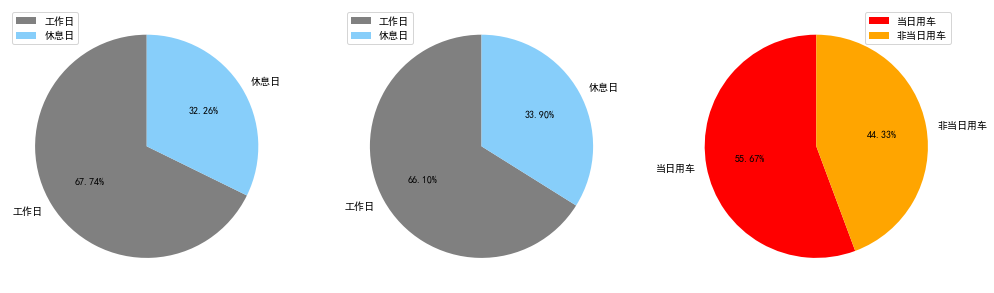

In [219]:
fig = plt.figure(figsize=(17,6))
color_list = [['gray','lightskyblue'],['gray','lightskyblue'],['red','orange']]
labels = [['工作日','休息日'],['工作日','休息日'],['当日用车','非当日用车']]
# x = np.arange(0, 100)  
for i,col in enumerate(['is_bookdate_holiday','is_orderdate_holiday','use_immediate']):
    axes = fig.add_subplot(1,3,int(i+1))
    x = df_user_order_detail[col].value_counts()
    plt.pie(x,autopct='%1.2f%%',labels=labels[i],colors=color_list[i],startangle=90)
    axes.legend(loc='best')
plt.show()

##### 如图所示：工作日，当日用车占比相对高

In [259]:
df_user_order_detail['book_month'].astype(se_order_month,inplace=True)

0        8
1        9
2       10
3        1
4        2
        ..
9995     8
9996    10
9997     1
9998     5
9999     6
Name: book_month, Length: 10000, dtype: category
Categories (12, int64): [7 < 8 < 9 < 10 ... 3 < 4 < 5 < 6]

In [261]:
df_user_order_detail.sort_values('book_month')

,trade_order_id,uid,gid,passenger_phone,platform,service_type,service_type_name,order_status,order_status_name,order_day,...,first_taken_driver_taken_type_name,order_car_type_id.1,order_car_type_name.1,source_type,source_type_name,is_bookdate_holiday,is_orderdate_holiday,use_immediate,order_month,book_month
4695,S181788196957,357008081097463,AED08FA1-77F5-C2EF-50CB-13FC7C6DE975,186nP4s0100,Q,1,送机,7,已确认款项,2019-01-27,...,保单自动指派(保单司机),1,经济型,1,专车,1,0,0,1,1
1869,E181784442334,C096FA78-4D3D-490B-AFEB-6EF314A8D96E,12084E08-1AB9-AB99-0067-175064D1887A,1369XP68319,Q,2,接机,7,已确认款项,2019-01-23,...,OTA司机接单,5,商务型,12,OTA,0,0,0,1,1
5227,E181769414804,DD04AF33-B05A-4968-9D56-0D9B2349FA47,B1B34673-6163-0A55-9167-F9273B7197A4,138pQRV0208,Q,2,接机,7,已确认款项,2019-01-08,...,OTA司机接单,2,舒适型,12,OTA,0,0,0,1,1
6048,E181780013052,1173CE0F-62C2-41F4-94B4-20E462191C57,93E5FDAE-7427-75E1-9620-50143C57AF39,183QC_K2229,Q,5,接站,7,已确认款项,2019-01-19,...,OTA司机接单,5,商务型,12,OTA,1,0,0,1,1
5228,E181783133234,862503033061698,A67DE605-2859-9B0C-6B11-12855F9D65AA,138begL4986,Q,2,接机,7,已确认款项,2019-01-22,...,OTA司机接单,5,商务型,12,OTA,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,S181757701822,867960032414606,93D11584-487A-4D9A-9549-1F24ED408C5C,158XlOl1901,Q,2,接机,7,已确认款项,2018-12-27,...,保单自动指派(保单司机),1,经济型,1,专车,0,1,0,12,12
648,E181740067572,97C8BE0C-FA24-43CB-B1C6-CFA837770FBB,C3BC78F8-E4F4-CF1C-0AD4-A6C8C67A9DC3,189QEIW5844,Q,5,接站,7,已确认款项,2018-12-10,...,OTA司机接单,1,经济型,12,OTA,0,0,1,12,12
6964,S181757875538,867165035360760,B1F8E0D4-03CD-79C4-B560-46C330D67E76,139QAKz4492,Q,2,接机,7,已确认款项,2018-12-27,...,保单自动指派(保单司机),2,舒适型,1,专车,0,1,0,12,12
7031,S181751046605,FB398E41-F9B8-4ED4-AD65-ECDEFCFEA093,D549584B-CD54-203E-758F-1A29BA1A4CD6,150GR=79939,Q,1,送机,8,取消,2018-12-21,...,保单自动指派(保单司机),2,舒适型,1,专车,0,1,0,12,12


In [249]:
se_order_month = CategoricalDtype([7,8,9,10,11,12,1,2,3,4,5,6],ordered=True)

([<matplotlib.axis.XTick at 0x20e1bbba9b0>,
 <a list of 12 Text xticklabel objects>)

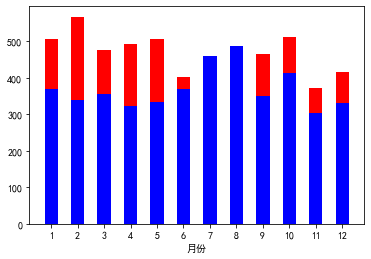

In [265]:
month_queue = [7,8,9,10,11,12,1,2,3,4,5,6]     # 暂时手动定
y_0 = df_user_order_detail[df_user_order_detail['use_immediate']==0]['book_month'].value_counts().sort_values(ascending=True)
y_1 = df_user_order_detail[df_user_order_detail['use_immediate']==1]['book_month'].value_counts().sort_values(ascending=True)
plt.bar(range(1,13),y_0,width=0.5,color='red',label='非当日用车')
plt.bar(range(1,13),y_1,width=0.5,color='blue',label='当日用车')
plt.xlabel('月份')
plt.xticks(range(1,13))

##### 当日用车订单数无明显变化，非当日用车订单数开始增加，占比逐渐增大 (自定义月份顺序无效)